In [1]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import builtins
%matplotlib inline
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
print(f" starting eda")


 starting eda


In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("AirbnbPricePredictor") \
    .master("local[*]") \
    .config("spark.driver.extraJavaOptions", "-Djava.security.manager=allow") \
    .config("spark.executor.extraJavaOptions", "-Djava.security.manager=allow") \
    .getOrCreate()
print(f" spark session connected")


25/11/16 23:40:52 WARN Utils: Your hostname, MacBook-Pro-110.local resolves to a loopback address: 127.0.0.1; using 192.168.1.103 instead (on interface en0)
25/11/16 23:40:52 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/16 23:40:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


 spark session connected


In [3]:
df = spark.read.parquet("../data/processed/listings_features.parquet")
print(f"data loaded: {df.count():,} rows, {len(df.columns)} columns")

data loaded: 118,240 rows, 44 columns


## 1. Price Distribution Analysis

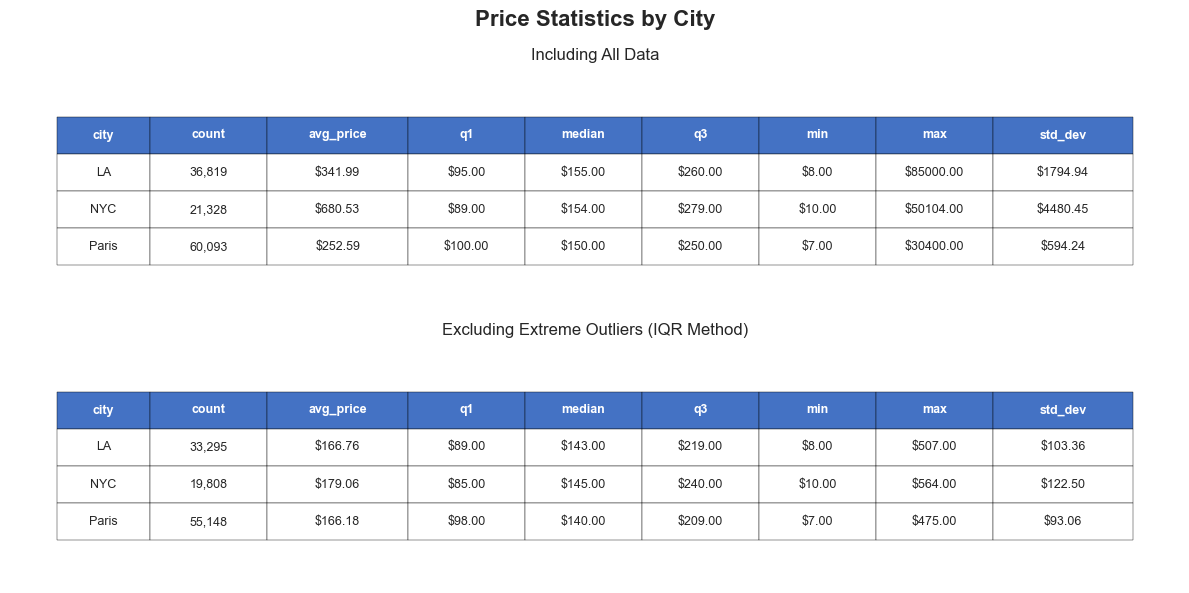

In [4]:
# compute price statistics with all data
price_stats = df.groupBy("city").agg(
    count("*").alias("count"),
    avg("price").alias("avg_price"),
    expr("percentile(price, 0.25)").alias("q1"),
    expr("percentile(price, 0.5)").alias("median"),
    expr("percentile(price, 0.75)").alias("q3"),
    min("price").alias("min"),
    max("price").alias("max"),
    stddev("price").alias("std_dev")
).orderBy("city").toPandas()

# compute outlier bounds based on original unfiltered data
bounds = df.groupBy("city").agg(
    expr("percentile(price, 0.25)").alias("q1"),
    expr("percentile(price, 0.75)").alias("q3")
).withColumn("iqr", col("q3") - col("q1")) \
 .withColumn("lower", col("q1") - 1.5 * col("iqr")) \
 .withColumn("upper", col("q3") + 1.5 * col("iqr"))

# If outlier columns already exist, remove them to make this idempotent
col_names = df.columns
tmp_df = df
for c in ['q1', 'q3', 'iqr', 'lower', 'upper']:
    if c in col_names:
        tmp_df = tmp_df.drop(c)

df_outlier_removed = tmp_df.join(bounds, on="city", how="left") \
    .where((col("price") >= col("lower")) & (col("price") <= col("upper")))

price_stats_no_outliers = df_outlier_removed.groupBy("city").agg(
    count("*").alias("count"),
    avg("price").alias("avg_price"),
    expr("percentile(price, 0.25)").alias("q1"),
    expr("percentile(price, 0.5)").alias("median"),
    expr("percentile(price, 0.75)").alias("q3"),
    min("price").alias("min"),
    max("price").alias("max"),
    stddev("price").alias("std_dev")
).orderBy("city").toPandas()


# create charts
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
fig.suptitle('Price Statistics by City', fontsize=16, fontweight='bold')

# Table 1: With outliers
price_stats_formatted = price_stats.copy()
for col in ['avg_price', 'q1', 'median', 'q3', 'min', 'max', 'std_dev']:
    price_stats_formatted[col] = price_stats_formatted[col].apply(lambda x: f'${x:.2f}')
price_stats_formatted['count'] = price_stats_formatted['count'].apply(lambda x: f'{x:,}')

ax1.axis('tight')
ax1.axis('off')
table1 = ax1.table(cellText=price_stats_formatted.values,
                   colLabels=price_stats_formatted.columns,
                   cellLoc='center',
                   loc='center',
                   colWidths=[0.08, 0.1, 0.12, 0.1, 0.1, 0.1, 0.1, 0.1, 0.12])
table1.auto_set_font_size(False)
table1.set_fontsize(9)
table1.scale(1, 2)
for i in range(len(price_stats_formatted.columns)):
    table1[(0, i)].set_facecolor('#4472C4')
    table1[(0, i)].set_text_props(weight='bold', color='white')
ax1.set_title('Including All Data', fontsize=12, pad=10)

# Table 2: Without outliers
price_stats_no_outliers_formatted = price_stats_no_outliers.copy()
for col in ['avg_price', 'q1', 'median', 'q3', 'min', 'max', 'std_dev']:
    price_stats_no_outliers_formatted[col] = price_stats_no_outliers_formatted[col].apply(lambda x: f'${x:.2f}')
price_stats_no_outliers_formatted['count'] = price_stats_no_outliers_formatted['count'].apply(lambda x: f'{x:,}')

ax2.axis('tight')
ax2.axis('off')
table2 = ax2.table(cellText=price_stats_no_outliers_formatted.values,
                   colLabels=price_stats_no_outliers_formatted.columns,
                   cellLoc='center',
                   loc='center',
                   colWidths=[0.08, 0.1, 0.12, 0.1, 0.1, 0.1, 0.1, 0.1, 0.12])
table2.auto_set_font_size(False)
table2.set_fontsize(9)
table2.scale(1, 2)
for i in range(len(price_stats_no_outliers_formatted.columns)):
    table2[(0, i)].set_facecolor('#4472C4')
    table2[(0, i)].set_text_props(weight='bold', color='white')
ax2.set_title('Excluding Extreme Outliers (IQR Method)', fontsize=12, pad=10)

plt.tight_layout()
plt.savefig('../outputs/figures/price_statistics_table.png', dpi=300, bbox_inches='tight')
plt.show()

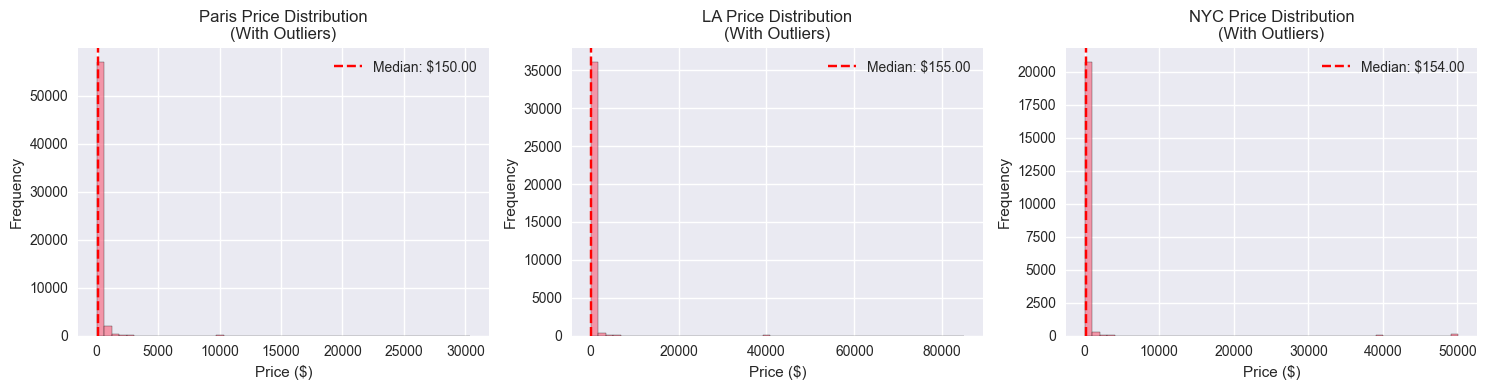

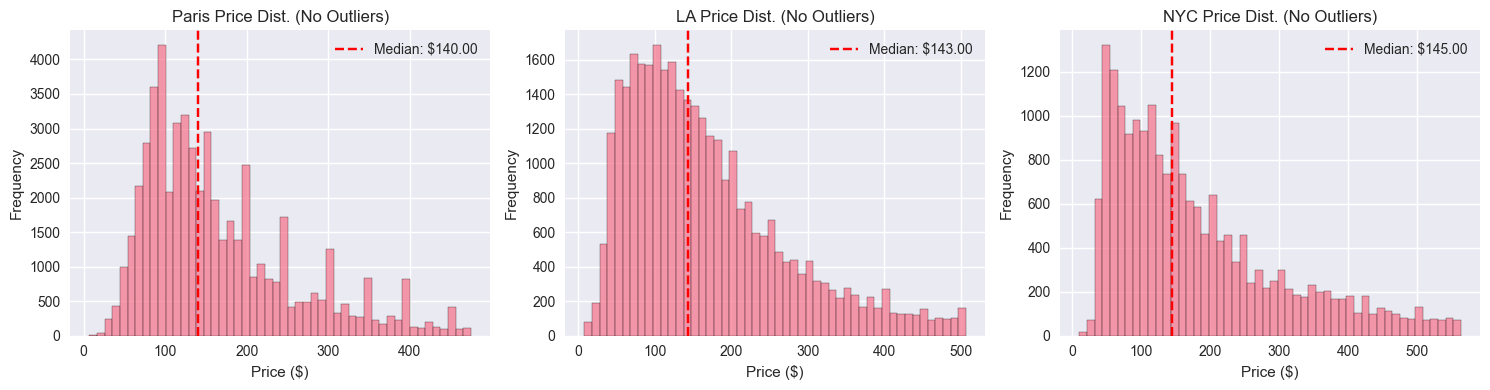

In [5]:
price_data = df.select("city", "price").toPandas()
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
cities = price_data['city'].unique()
for i, city in enumerate(cities):
    city_prices = price_data[price_data['city'] == city]['price']
    axes[i].hist(city_prices, bins=50, edgecolor='black', alpha=0.7)
    axes[i].set_title(f'{city} Price Distribution\n(With Outliers)')
    axes[i].set_xlabel('Price ($)')
    axes[i].set_ylabel('Frequency')
    axes[i].axvline(city_prices.median(), color='red', linestyle='--', label=f'Median: ${city_prices.median():.2f}')
    axes[i].legend()
plt.tight_layout()
plt.savefig('../outputs/figures/price_distribution_histograms.png', dpi=300, bbox_inches='tight')
plt.show()
price_data_no_outliers = df_outlier_removed.select("city", "price").toPandas()
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
cities_no_outliers = price_data_no_outliers['city'].unique()
for i, city in enumerate(cities_no_outliers):
    city_prices = price_data_no_outliers[price_data_no_outliers['city'] == city]['price']
    axes[i].hist(city_prices, bins=50, edgecolor='black', alpha=0.7)
    axes[i].set_title(f'{city} Price Dist. (No Outliers)')
    axes[i].set_xlabel('Price ($)')
    axes[i].set_ylabel('Frequency')
    axes[i].axvline(city_prices.median(), color='red', linestyle='--', label=f'Median: ${city_prices.median():.2f}')
    axes[i].legend()
plt.tight_layout()
plt.savefig('../outputs/figures/price_distribution_histograms.png', dpi=300, bbox_inches='tight')
plt.show()

In [6]:
df = df_outlier_removed
output_path = "../data/processed/listings_features_no_outliers.parquet"
print(f"saving outlier-free dataset to {output_path}...")
df.write.mode("overwrite").parquet(output_path)
print(f" saved {df.count():,} rows (outliers removed)")


saving outlier-free dataset to ../data/processed/listings_features_no_outliers.parquet...


25/11/16 23:41:00 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


 saved 108,251 rows (outliers removed)


## 2. Room Type Analysis

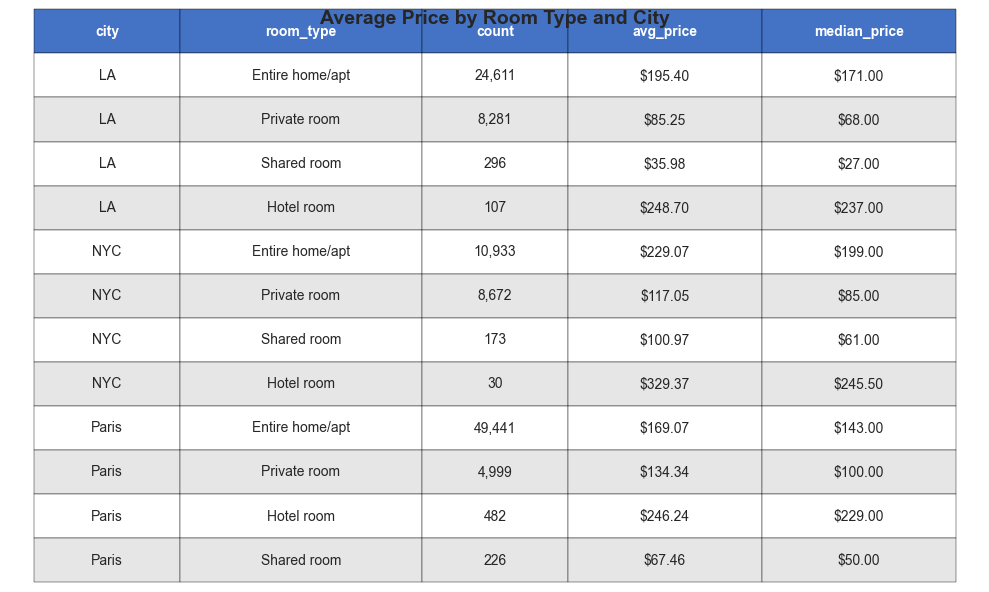

In [7]:
# Average price by room type and city
room_analysis = df.groupBy("city", "room_type").agg(
    count("*").alias("count"),
    avg("price").alias("avg_price"),
    expr("percentile(price, 0.5)").alias("median_price")
).orderBy("city", desc("count")).toPandas()

# formatting
room_analysis_formatted = room_analysis.copy()
room_analysis_formatted['avg_price'] = room_analysis_formatted['avg_price'].apply(lambda x: f'${x:.2f}')
room_analysis_formatted['median_price'] = room_analysis_formatted['median_price'].apply(lambda x: f'${x:.2f}')
room_analysis_formatted['count'] = room_analysis_formatted['count'].apply(lambda x: f'{x:,}')

# create table
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=room_analysis_formatted.values,
                colLabels=room_analysis_formatted.columns,
                cellLoc='center',
                loc='center',
                colWidths=[0.15, 0.25, 0.15, 0.2, 0.2])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)

# styling
for i in range(len(room_analysis_formatted.columns)):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')

# alternative row colors
for i in range(1, len(room_analysis_formatted) + 1):
    for j in range(len(room_analysis_formatted.columns)):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#E7E6E6')

plt.title('Average Price by Room Type and City', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../outputs/figures/room_type_price_table.png', dpi=300, bbox_inches='tight')
plt.show()

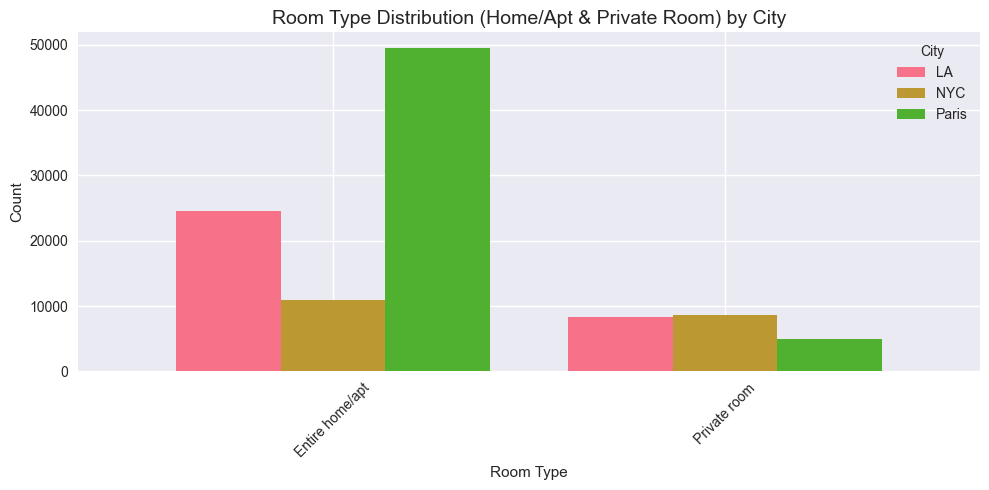

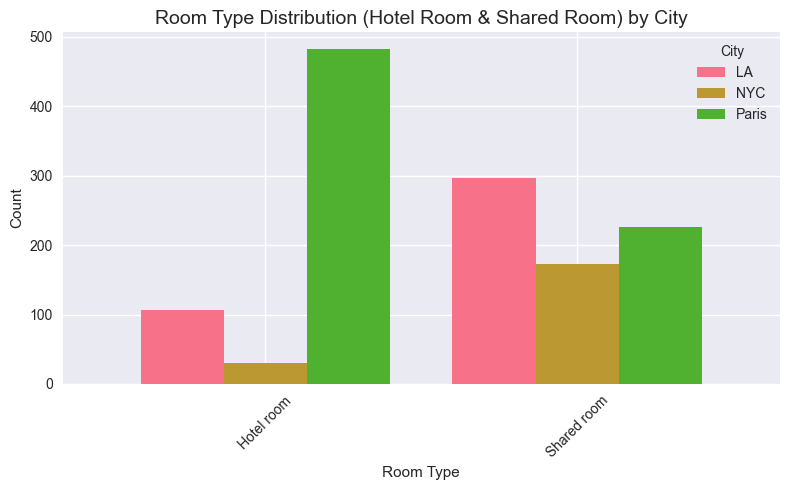

In [8]:
room_dist = df.groupBy("city", "room_type").count()
room_dist_pd = room_dist.toPandas()
group1_types = ['Entire home/apt', 'Private room']
room_dist_group1 = room_dist_pd[room_dist_pd['room_type'].isin(group1_types)]
pivot1 = room_dist_group1.pivot(index='room_type', columns='city', values='count').fillna(0)
group2_types = ['Hotel room', 'Shared room']
room_dist_group2 = room_dist_pd[room_dist_pd['room_type'].isin(group2_types)]
pivot2 = room_dist_group2.pivot(index='room_type', columns='city', values='count').fillna(0)
ax1 = pivot1.plot(kind='bar', figsize=(10, 5), width=0.8)
ax1.set_title('Room Type Distribution (Home/Apt & Private Room) by City', fontsize=14)
ax1.set_xlabel('Room Type')
ax1.set_ylabel('Count')
ax1.legend(title='City')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../outputs/figures/room_type_distribution_charts.png', dpi=300, bbox_inches='tight')
plt.show()
ax2 = pivot2.plot(kind='bar', figsize=(8, 5), width=0.8)
ax2.set_title('Room Type Distribution (Hotel Room & Shared Room) by City', fontsize=14)
ax2.set_xlabel('Room Type')
ax2.set_ylabel('Count')
ax2.legend(title='City')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../outputs/figures/room_type_distribution_charts.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. Property Type Analysis

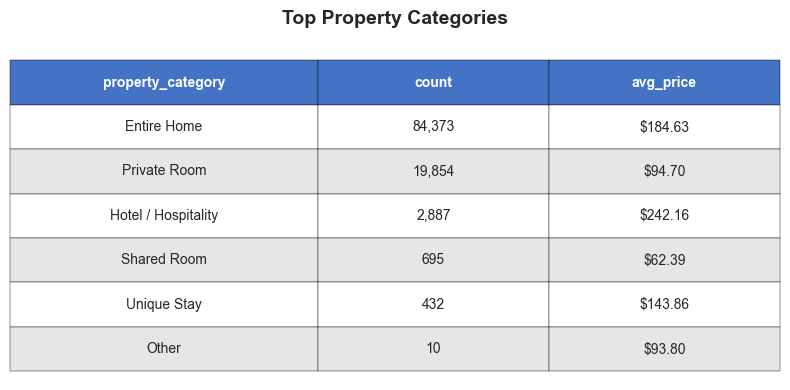

In [9]:
# Top property categories
prop_analysis = df.groupBy("property_category").agg(
    count("*").alias("count"),
    avg("price").alias("avg_price")
).orderBy(desc("count")).toPandas()

# formatting
prop_analysis_formatted = prop_analysis.copy()
prop_analysis_formatted['avg_price'] = prop_analysis_formatted['avg_price'].apply(lambda x: f'${x:.2f}')
prop_analysis_formatted['count'] = prop_analysis_formatted['count'].apply(lambda x: f'{x:,}')

# create table
fig, ax = plt.subplots(figsize=(8, 4))
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=prop_analysis_formatted.values,
                colLabels=prop_analysis_formatted.columns,
                cellLoc='center',
                loc='center',
                colWidths=[0.4, 0.3, 0.3])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)

# style
for i in range(len(prop_analysis_formatted.columns)):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')

# alternate row colors
for i in range(1, len(prop_analysis_formatted) + 1):
    for j in range(len(prop_analysis_formatted.columns)):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#E7E6E6')

plt.title('Top Property Categories', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../outputs/figures/property_categories_table.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Accommodates vs Price

25/11/16 23:41:03 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


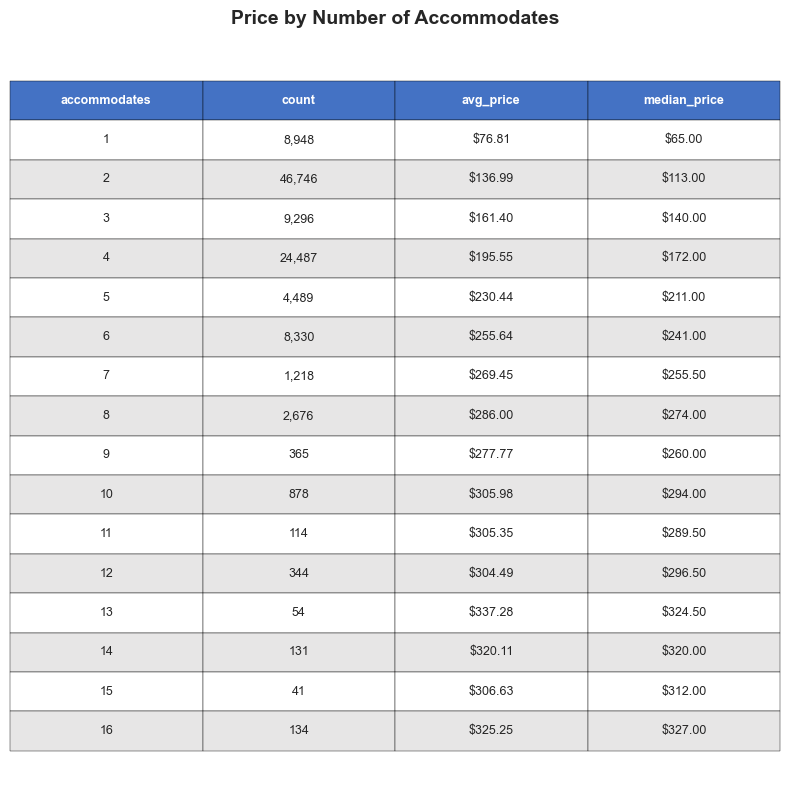

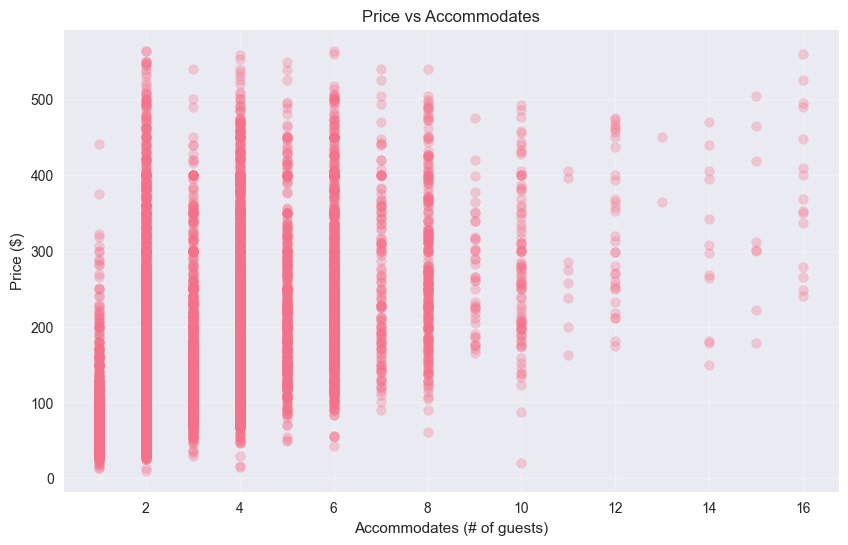

In [10]:
accommodates_analysis = df.groupBy("accommodates").agg(
    count("*").alias("count"),
    avg("price").alias("avg_price"),
    expr("percentile(price, 0.5)").alias("median_price")
).orderBy("accommodates").toPandas()

# formatting
accommodates_formatted = accommodates_analysis.copy()
accommodates_formatted['avg_price'] = accommodates_formatted['avg_price'].apply(lambda x: f'${x:.2f}')
accommodates_formatted['median_price'] = accommodates_formatted['median_price'].apply(lambda x: f'${x:.2f}')
accommodates_formatted['count'] = accommodates_formatted['count'].apply(lambda x: f'{x:,}')

# create table
fig, ax = plt.subplots(figsize=(8, 8))
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=accommodates_formatted.values,
                colLabels=accommodates_formatted.columns,
                cellLoc='center',
                loc='center',
                colWidths=[0.25, 0.25, 0.25, 0.25])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)

# style
for i in range(len(accommodates_formatted.columns)):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')

# alternate row colors
for i in range(1, len(accommodates_formatted) + 1):
    for j in range(len(accommodates_formatted.columns)):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#E7E6E6')

plt.title("Price by Number of Accommodates", fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../outputs/figures/accommodates_vs_price_table.png', dpi=300, bbox_inches='tight')
plt.savefig('../outputs/figures/accommodates_vs_price_table.png', dpi=300, bbox_inches='tight')
plt.show()
acc_data = df.select("accommodates", "price").sample(0.1).toPandas()
plt.figure(figsize=(10, 6))
plt.scatter(acc_data['accommodates'], acc_data['price'], alpha=0.3)
plt.xlabel('Accommodates (# of guests)')
plt.ylabel('Price ($)')
plt.title('Price vs Accommodates')
plt.grid(True, alpha=0.3)
plt.savefig('../outputs/figures/accommodates_vs_price_table.png', dpi=300, bbox_inches='tight')
plt.savefig('../outputs/figures/accommodates_vs_price_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Superhost Impact

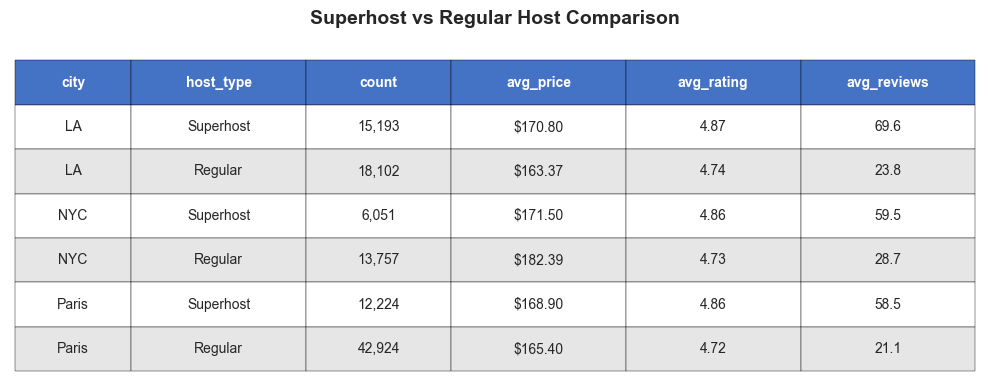

In [11]:
# Superhost vs regular host comparison
superhost_analysis = df.groupBy("city", "host_is_superhost").agg(
    count("*").alias("count"),
    avg("price").alias("avg_price"),
    avg("review_scores_rating").alias("avg_rating"),
    avg("number_of_reviews").alias("avg_reviews")
).orderBy("city", desc("host_is_superhost")).toPandas()

# Add superhost label
superhost_analysis['host_type'] = superhost_analysis['host_is_superhost'].apply(
    lambda x: 'Superhost' if x == 1 else 'Regular'
)

# formatting
superhost_formatted = superhost_analysis[['city', 'host_type', 'count', 'avg_price', 'avg_rating', 'avg_reviews']].copy()
superhost_formatted['avg_price'] = superhost_formatted['avg_price'].apply(lambda x: f'${x:.2f}')
superhost_formatted['avg_rating'] = superhost_formatted['avg_rating'].apply(lambda x: f'{x:.2f}')
superhost_formatted['avg_reviews'] = superhost_formatted['avg_reviews'].apply(lambda x: f'{x:.1f}')
superhost_formatted['count'] = superhost_formatted['count'].apply(lambda x: f'{x:,}')

# create table
fig, ax = plt.subplots(figsize=(10, 4))
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=superhost_formatted.values,
                colLabels=superhost_formatted.columns,
                cellLoc='center',
                loc='center',
                colWidths=[0.12, 0.18, 0.15, 0.18, 0.18, 0.18])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)

# style
for i in range(len(superhost_formatted.columns)):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')

# alternate row colors
for i in range(1, len(superhost_formatted) + 1):
    for j in range(len(superhost_formatted.columns)):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#E7E6E6')

plt.title('Superhost vs Regular Host Comparison', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../outputs/figures/superhost_comparison_table.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Neighborhood Analysis

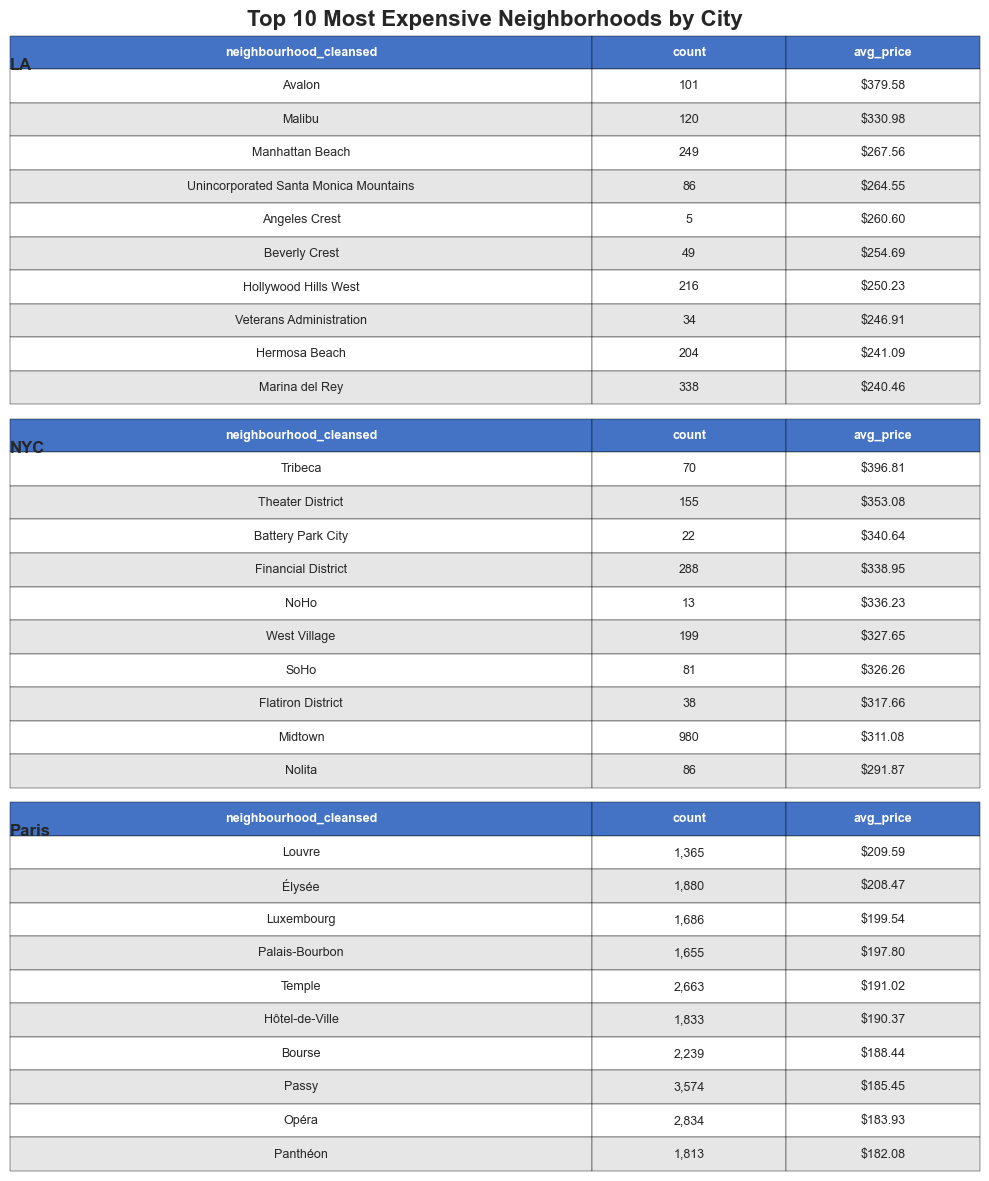

In [12]:
from pyspark.sql.functions import col, count, avg, desc

cities = df.select("city").distinct().rdd.flatMap(lambda x: x).collect()
fig, axes = plt.subplots(len(cities), 1, figsize=(10, 12))
fig.suptitle('Top 10 Most Expensive Neighborhoods by City', fontsize=16, fontweight='bold')

if len(cities) == 1:
    axes = [axes]

for idx, city_name in enumerate(sorted(cities)):
    top_neighborhoods = df.filter(col("city") == city_name) \
        .groupBy("neighbourhood_cleansed").agg(
            count("*").alias("count"),
            avg("price").alias("avg_price")
        ).filter(col("count") >= 5) \
        .orderBy(desc("avg_price")) \
        .limit(10).toPandas()
    
    # formatting
    top_neighborhoods_formatted = top_neighborhoods.copy()
    top_neighborhoods_formatted['avg_price'] = top_neighborhoods_formatted['avg_price'].apply(lambda x: f'${x:.2f}')
    top_neighborhoods_formatted['count'] = top_neighborhoods_formatted['count'].apply(lambda x: f'{x:,}')
    
    ax = axes[idx]
    ax.axis('tight')
    ax.axis('off')
    
    table = ax.table(cellText=top_neighborhoods_formatted.values,
                    colLabels=top_neighborhoods_formatted.columns,
                    cellLoc='center',
                    loc='center',
                    colWidths=[0.6, 0.2, 0.2])
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2)
    
    # style
    for i in range(len(top_neighborhoods_formatted.columns)):
        table[(0, i)].set_facecolor('#4472C4')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # alternate row colors
    for i in range(1, len(top_neighborhoods_formatted) + 1):
        for j in range(len(top_neighborhoods_formatted.columns)):
            if i % 2 == 0:
                table[(i, j)].set_facecolor('#E7E6E6')
    
    ax.set_title(f'{city_name}', fontsize=12, pad=10, loc='left', fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/figures/top_neighborhoods_tables.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Bedrooms vs Price

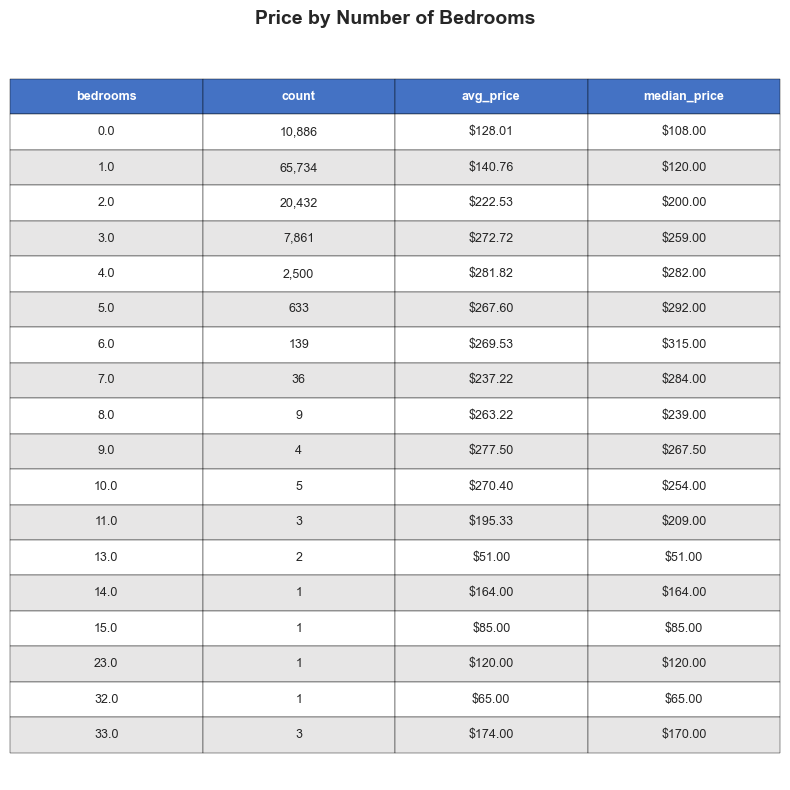

In [13]:
bedroom_analysis = df.groupBy("bedrooms").agg(
    count("*").alias("count"),
    avg("price").alias("avg_price"),
    expr("percentile(price, 0.5)").alias("median_price")
).orderBy("bedrooms").toPandas()

# formatting
bedroom_formatted = bedroom_analysis.copy()
bedroom_formatted['avg_price'] = bedroom_formatted['avg_price'].apply(lambda x: f'${x:.2f}')
bedroom_formatted['median_price'] = bedroom_formatted['median_price'].apply(lambda x: f'${x:.2f}')
bedroom_formatted['count'] = bedroom_formatted['count'].apply(lambda x: f'{x:,}')

# create table
fig, ax = plt.subplots(figsize=(8, 8))
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=bedroom_formatted.values,
                colLabels=bedroom_formatted.columns,
                cellLoc='center',
                loc='center',
                colWidths=[0.25, 0.25, 0.25, 0.25])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 1.8)

# style
for i in range(len(bedroom_formatted.columns)):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')

# alternate row colors
for i in range(1, len(bedroom_formatted) + 1):
    for j in range(len(bedroom_formatted.columns)):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#E7E6E6')

plt.title('Price by Number of Bedrooms', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../outputs/figures/bedrooms_price_table.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Reviews and Rating Analysis

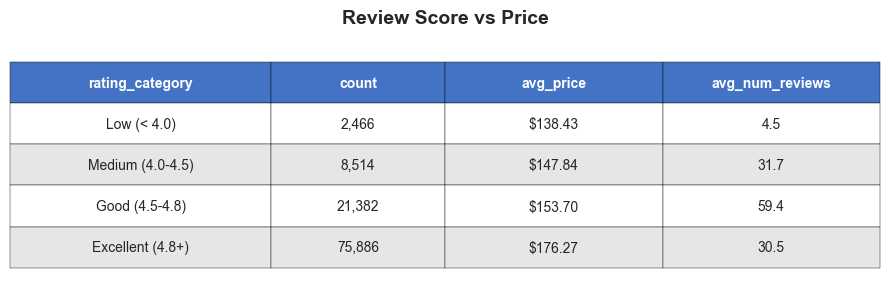

In [14]:
# Review score vs price
review_analysis = df.filter(col("review_scores_rating") > 0) \
    .withColumn("rating_category",
        when(col("review_scores_rating") < 4.0, "Low (< 4.0)")
        .when(col("review_scores_rating") < 4.5, "Medium (4.0-4.5)")
        .when(col("review_scores_rating") < 4.8, "Good (4.5-4.8)")
        .otherwise("Excellent (4.8+)")
    ).groupBy("rating_category").agg(
        count("*").alias("count"),
        avg("price").alias("avg_price"),
        avg("number_of_reviews").alias("avg_num_reviews")
    ) \
    .withColumn(
        "rating_order",
        when(col("rating_category") == "Low (< 4.0)", 1)
        .when(col("rating_category") == "Medium (4.0-4.5)", 2)
        .when(col("rating_category") == "Good (4.5-4.8)", 3)
        .when(col("rating_category") == "Excellent (4.8+)", 4)
        .otherwise(5)
    ) \
    .orderBy("rating_order").toPandas()

review_analysis = review_analysis.drop(columns=['rating_order'])

# formatting
review_formatted = review_analysis.copy()
review_formatted['avg_price'] = review_formatted['avg_price'].apply(lambda x: f'${x:.2f}')
review_formatted['avg_num_reviews'] = review_formatted['avg_num_reviews'].apply(lambda x: f'{x:.1f}')
review_formatted['count'] = review_formatted['count'].apply(lambda x: f'{x:,}')

# create table
fig, ax = plt.subplots(figsize=(9, 3))
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=review_formatted.values,
                colLabels=review_formatted.columns,
                cellLoc='center',
                loc='center',
                colWidths=[0.3, 0.2, 0.25, 0.25])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)

# style
for i in range(len(review_formatted.columns)):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')

# alternate row colors
for i in range(1, len(review_formatted) + 1):
    for j in range(len(review_formatted.columns)):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#E7E6E6')

plt.title('Review Score vs Price', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../outputs/figures/review_score_price_table.png', dpi=300, bbox_inches='tight')
plt.show()

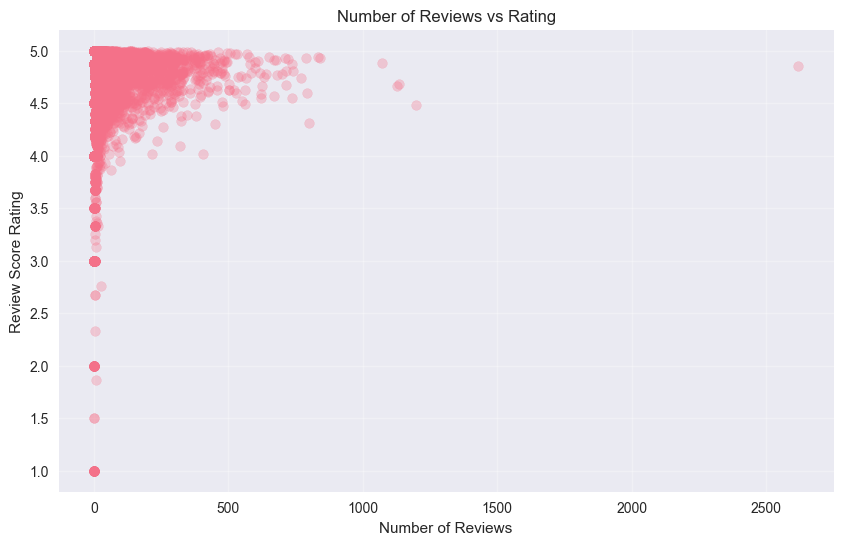

In [15]:
review_data = df.select("number_of_reviews", "review_scores_rating") \
    .filter(col("review_scores_rating") > 0) \
    .sample(0.1).toPandas()
plt.figure(figsize=(10, 6))
plt.scatter(review_data['number_of_reviews'], review_data['review_scores_rating'], alpha=0.3)
plt.xlabel('Number of Reviews')
plt.ylabel('Review Score Rating')
plt.title('Number of Reviews vs Rating')
plt.grid(True, alpha=0.3)
plt.savefig('../outputs/figures/reviews_vs_rating_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

## 9. Availability Analysis

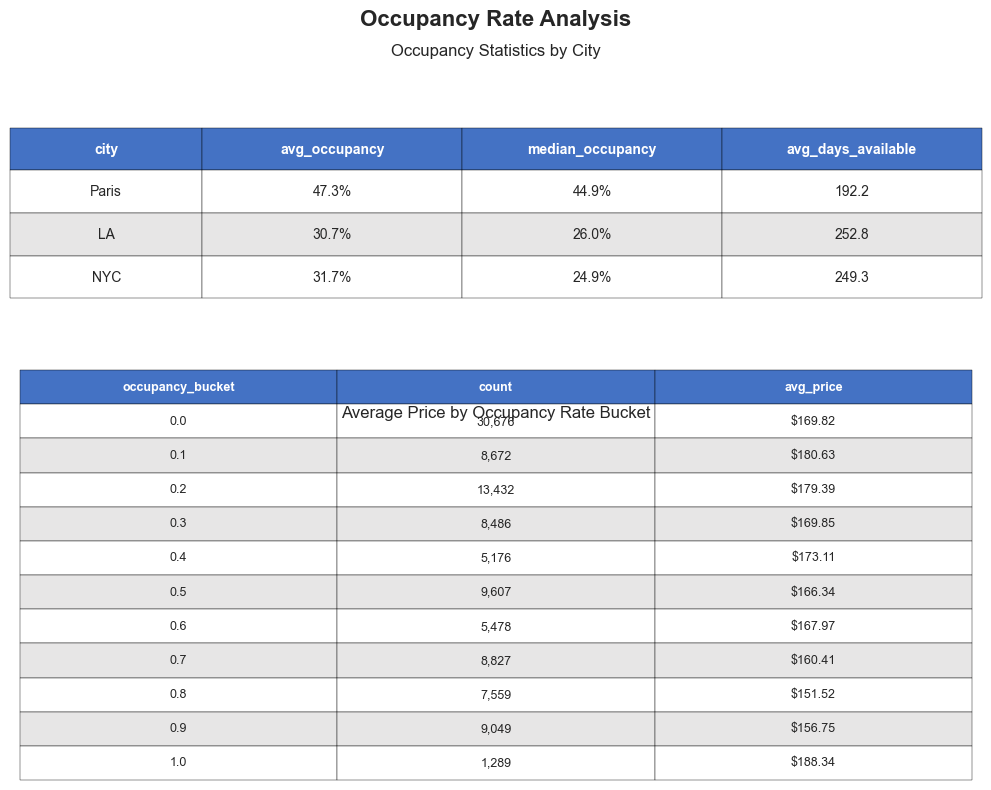

In [16]:
# occupancy rate statistics
occupancy_stats = df.groupBy("city").agg(
    avg("occupancy_rate").alias("avg_occupancy"),
    expr("percentile(occupancy_rate, 0.5)").alias("median_occupancy"),
    avg("availability_365").alias("avg_days_available")
).toPandas()

occupancy_price = df.withColumn("occupancy_bucket",
    (col("occupancy_rate") * 10).cast("int") / 10
).groupBy("occupancy_bucket").agg(
    count("*").alias("count"),
    avg("price").alias("avg_price")
).orderBy("occupancy_bucket").toPandas()

# create tables
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
fig.suptitle('Occupancy Rate Analysis', fontsize=16, fontweight='bold')

# Table 1: Occupancy by city
occupancy_stats_formatted = occupancy_stats.copy()
occupancy_stats_formatted['avg_occupancy'] = occupancy_stats_formatted['avg_occupancy'].apply(lambda x: f'{x:.1%}')
occupancy_stats_formatted['median_occupancy'] = occupancy_stats_formatted['median_occupancy'].apply(lambda x: f'{x:.1%}')
occupancy_stats_formatted['avg_days_available'] = occupancy_stats_formatted['avg_days_available'].apply(lambda x: f'{x:.1f}')

ax1.axis('tight')
ax1.axis('off')
table1 = ax1.table(cellText=occupancy_stats_formatted.values,
                   colLabels=occupancy_stats_formatted.columns,
                   cellLoc='center',
                   loc='center',
                   colWidths=[0.2, 0.27, 0.27, 0.27])
table1.auto_set_font_size(False)
table1.set_fontsize(10)
table1.scale(1, 2.5)
for i in range(len(occupancy_stats_formatted.columns)):
    table1[(0, i)].set_facecolor('#4472C4')
    table1[(0, i)].set_text_props(weight='bold', color='white')
for i in range(1, len(occupancy_stats_formatted) + 1):
    for j in range(len(occupancy_stats_formatted.columns)):
        if i % 2 == 0:
            table1[(i, j)].set_facecolor('#E7E6E6')
ax1.set_title('Occupancy Statistics by City', fontsize=12, pad=10)

# Table 2: Price by occupancy bucket
occupancy_price_formatted = occupancy_price.copy()
occupancy_price_formatted['occupancy_bucket'] = occupancy_price_formatted['occupancy_bucket'].apply(lambda x: f'{x:.1f}')
occupancy_price_formatted['avg_price'] = occupancy_price_formatted['avg_price'].apply(lambda x: f'${x:.2f}')
occupancy_price_formatted['count'] = occupancy_price_formatted['count'].apply(lambda x: f'{x:,}')

ax2.axis('tight')
ax2.axis('off')
table2 = ax2.table(cellText=occupancy_price_formatted.values,
                   colLabels=occupancy_price_formatted.columns,
                   cellLoc='center',
                   loc='center',
                   colWidths=[0.33, 0.33, 0.33])
table2.auto_set_font_size(False)
table2.set_fontsize(9)
table2.scale(1, 2)
for i in range(len(occupancy_price_formatted.columns)):
    table2[(0, i)].set_facecolor('#4472C4')
    table2[(0, i)].set_text_props(weight='bold', color='white')
for i in range(1, len(occupancy_price_formatted) + 1):
    for j in range(len(occupancy_price_formatted.columns)):
        if i % 2 == 0:
            table2[(i, j)].set_facecolor('#E7E6E6')
ax2.set_title('Average Price by Occupancy Rate Bucket', fontsize=12, pad=10)

plt.tight_layout()
plt.savefig('../outputs/figures/occupancy_analysis_tables.png', dpi=300, bbox_inches='tight')
plt.show()

## 10. Distance to Center Analysis

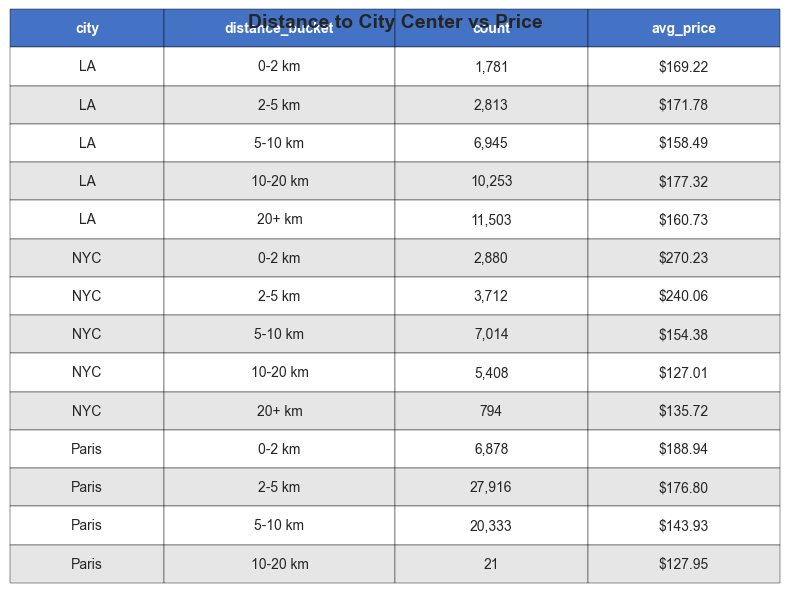

In [17]:
# Distance to city center vs price
def get_distance_order(bucket):
    orders = {
        "0-2 km": 0,
        "2-5 km": 1,
        "5-10 km": 2,
        "10-20 km": 3,
        "20+ km": 4
    }
    return orders.get(bucket, 99)

get_distance_order_udf = udf(get_distance_order, IntegerType())
distance_analysis = df.withColumn("distance_bucket",
    when(col("distance_to_center") < 2, "0-2 km")
    .when(col("distance_to_center") < 5, "2-5 km")
    .when(col("distance_to_center") < 10, "5-10 km")
    .when(col("distance_to_center") < 20, "10-20 km")
    .otherwise("20+ km")
).withColumn("distance_order", get_distance_order_udf(col("distance_bucket"))) \
.groupBy("city", "distance_bucket", "distance_order").agg(
    count("*").alias("count"),
    avg("price").alias("avg_price")
).orderBy("city", "distance_order").toPandas()

distance_analysis = distance_analysis.drop(columns=['distance_order'])

# formatting
distance_formatted = distance_analysis.copy()
distance_formatted['avg_price'] = distance_formatted['avg_price'].apply(lambda x: f'${x:.2f}')
distance_formatted['count'] = distance_formatted['count'].apply(lambda x: f'{x:,}')

# create table
fig, ax = plt.subplots(figsize=(8, 6))
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=distance_formatted.values,
                colLabels=distance_formatted.columns,
                cellLoc='center',
                loc='center',
                colWidths=[0.2, 0.3, 0.25, 0.25])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.2)

# style
for i in range(len(distance_formatted.columns)):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')

# alternate row colors
for i in range(1, len(distance_formatted) + 1):
    for j in range(len(distance_formatted.columns)):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#E7E6E6')

plt.title('Distance to City Center vs Price', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../outputs/figures/distance_center_price_table.png', dpi=300, bbox_inches='tight')
plt.show()

## 11. Correlation Analysis

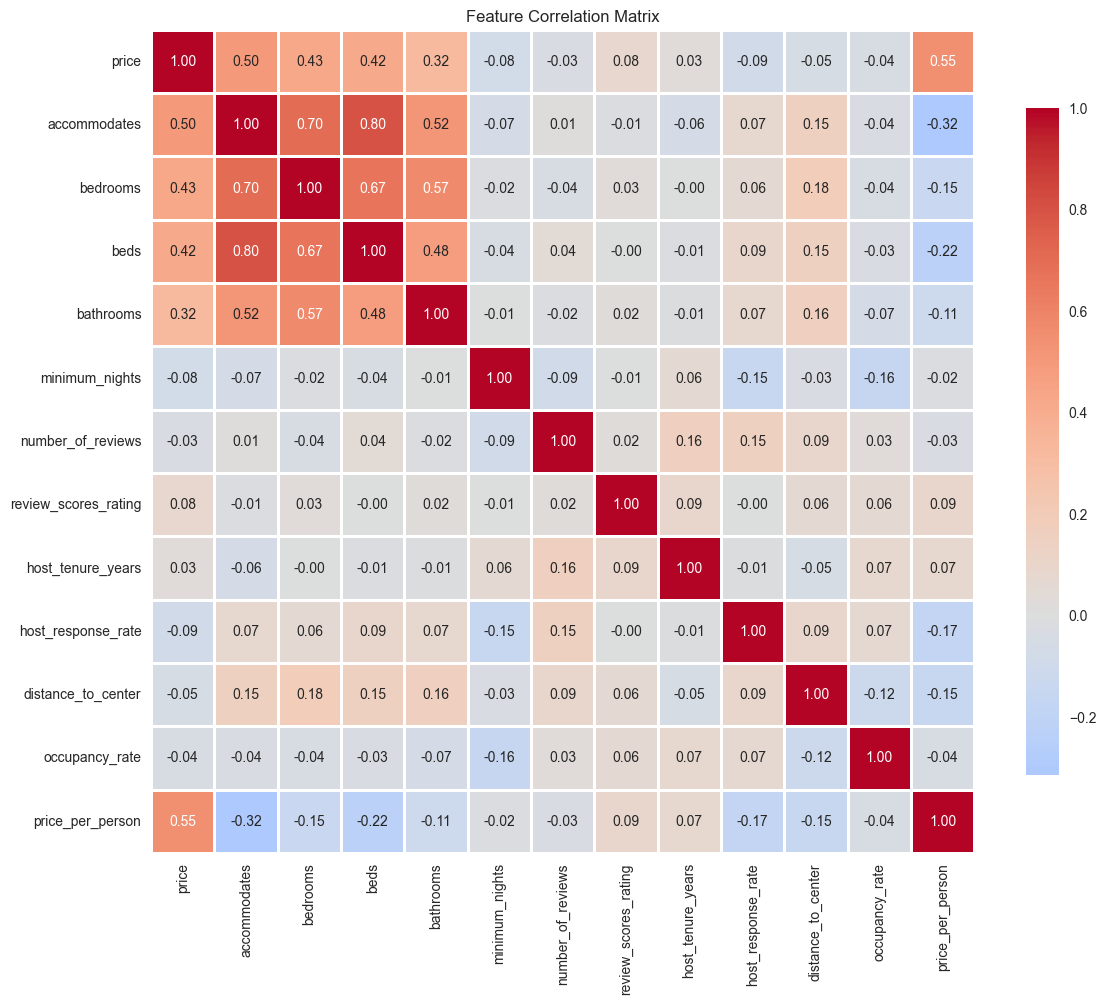

In [18]:
numeric_cols = [
    "price", "accommodates", "bedrooms", "beds", "bathrooms",
    "minimum_nights", "number_of_reviews", "review_scores_rating",
    "host_tenure_years", "host_response_rate",
    "distance_to_center", "occupancy_rate", "price_per_person"
]
corr_data = df.select(numeric_cols).sample(0.2).toPandas()
corr_matrix = corr_data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.savefig('../outputs/figures/correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

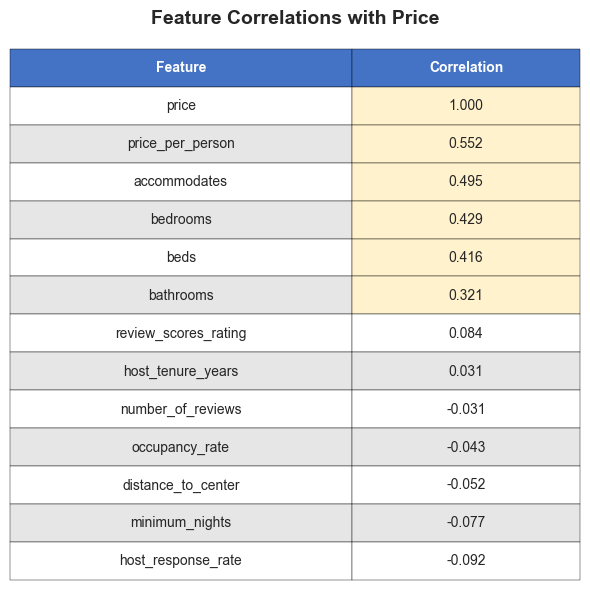

In [19]:
# Top correlations with price
price_corr = corr_matrix['price'].sort_values(ascending=False)
price_corr_df = pd.DataFrame({
    'Feature': price_corr.index,
    'Correlation': price_corr.values
})

price_corr_df['_Correlation_float'] = price_corr.values

# format for display
price_corr_formatted = price_corr_df.copy()
price_corr_formatted['Correlation'] = price_corr_formatted['Correlation'].apply(lambda x: f'{x:.3f}')

# create matplotlib table
fig, ax = plt.subplots(figsize=(6, 6))
ax.axis('tight')
ax.axis('off')

table = ax.table(
    cellText=price_corr_formatted[['Feature', 'Correlation']].values,
    colLabels=['Feature', 'Correlation'],
    cellLoc='center',
    loc='center',
    colWidths=[0.6, 0.4]
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# style header row
for i in range(2):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')

# alternate
for i in range(1, len(price_corr_formatted) + 1):
    corr_val = price_corr_df['_Correlation_float'].iloc[i - 1]  # Guaranteed to be float
    for j in range(2):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#E7E6E6')
        # Highlight strong correlations (abs > 0.3) in the 'Correlation' column only
        if j == 1 and builtins.abs(float(corr_val)) > 0.3:
            table[(i, j)].set_facecolor('#FFF2CC')

plt.title('Feature Correlations with Price', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../outputs/figures/price_correlations_table.png', dpi=300, bbox_inches='tight')
plt.show()

## 12. Minimum Nights Analysis

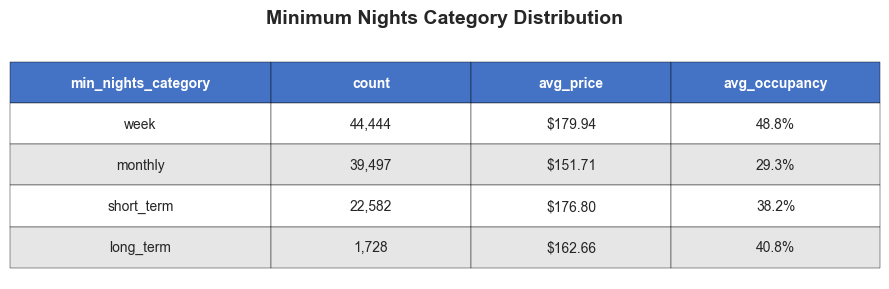

In [20]:
min_nights_dist = df.groupBy("min_nights_category").agg(
    count("*").alias("count"),
    avg("price").alias("avg_price"),
    avg("occupancy_rate").alias("avg_occupancy")
).orderBy(desc("count")).toPandas()

# format
min_nights_formatted = min_nights_dist.copy()
min_nights_formatted['avg_price'] = min_nights_formatted['avg_price'].apply(lambda x: f'${x:.2f}')
min_nights_formatted['avg_occupancy'] = min_nights_formatted['avg_occupancy'].apply(lambda x: f'{x:.1%}')
min_nights_formatted['count'] = min_nights_formatted['count'].apply(lambda x: f'{x:,}')

# create matplotlib table
fig, ax = plt.subplots(figsize=(9, 3))
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=min_nights_formatted.values,
                colLabels=min_nights_formatted.columns,
                cellLoc='center',
                loc='center',
                colWidths=[0.3, 0.23, 0.23, 0.24])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)

# style
for i in range(len(min_nights_formatted.columns)):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')

# alternate
for i in range(1, len(min_nights_formatted) + 1):
    for j in range(len(min_nights_formatted.columns)):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#E7E6E6')

plt.title('Minimum Nights Category Distribution', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../outputs/figures/min_nights_distribution_table.png', dpi=300, bbox_inches='tight')
plt.show()

## 13. Key Insights Summary

In [21]:
print(f"=" * 70)
print(f"key insights from eda")
print(f"=" * 70)
price_comp = df.groupBy("city").agg(avg("price").alias("avg_price")).collect()
print(f"\n1. average prices by city:")
for row in price_comp:
    print(f"   {row['city']}: ${row['avg_price']:.2f}")
pop_room = df.groupBy("room_type").count().orderBy(desc("count")).first()
print(f"\n2. most popular room type: {pop_room['room_type']} ({pop_room['count']:,} listings)")
sh_premium = df.groupBy("host_is_superhost").agg(avg("price")).collect()
if len(sh_premium) == 2:
    regular = [r['avg(price)'] for r in sh_premium if r['host_is_superhost'] == 0][0]
    superhost = [r['avg(price)'] for r in sh_premium if r['host_is_superhost'] == 1][0]
    premium = ((superhost - regular) / regular) * 100
    print(f"\n3. superhost price premium: {premium:.1f}%")
print(f"\n4. strongest price predictors (correlation > 0.3):")
strong_corr = corr_matrix['price'][corr_matrix['price'].abs() > 0.3].drop('price')
for feature, corr_val in strong_corr.items():
    print(f"   {feature}: {corr_val:.3f}")
print(f"\n" + "=" * 70)

key insights from eda

1. average prices by city:
   Paris: $166.18
   LA: $166.76
   NYC: $179.06

2. most popular room type: Entire home/apt (84,985 listings)

3. superhost price premium: 1.3%

4. strongest price predictors (correlation > 0.3):
   accommodates: 0.495
   bedrooms: 0.429
   beds: 0.416
   bathrooms: 0.321
   price_per_person: 0.552

